In [13]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

py_file_location = "/content/drive/Shareddrives/STUDENT-capstone-wi23/teamhranalytics/utilities/adspy_shared_utilities.py"
sys.path.append(os.path.abspath(py_file_location))
%cd /content/drive/Shareddrives/STUDENT-capstone-wi23/teamhranalytics/utilities/

random_state = 42

/content/drive/Shareddrives/STUDENT-capstone-wi23/teamhranalytics/utilities


In [25]:
ibm_data = pd.read_csv('/content/drive/Shareddrives/STUDENT-capstone-wi23/teamhranalytics/data/wa_fn-usec_-hr-employee-attrition.csv')

In [3]:
ibm_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


# EDA of IBM Dataset

In [4]:
ibm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [3]:
def catconsep(df):
  # https://www.kaggle.com/code/utkarshgaikwad1994/hr-attrition-utkarsh-gaikwad?scriptVersionId=117850320&cellId=22
    cat, con = [], []
    for i in df.columns:
        if df[i].dtype=='object':
            cat.append(i)
        else:
            con.append(i)
    return cat, con

In [16]:
cat,con = catconsep(ibm_data)

In [17]:
ibm_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
EmployeeNumber,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.00,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.00,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.00,2.0,3.00,5.0


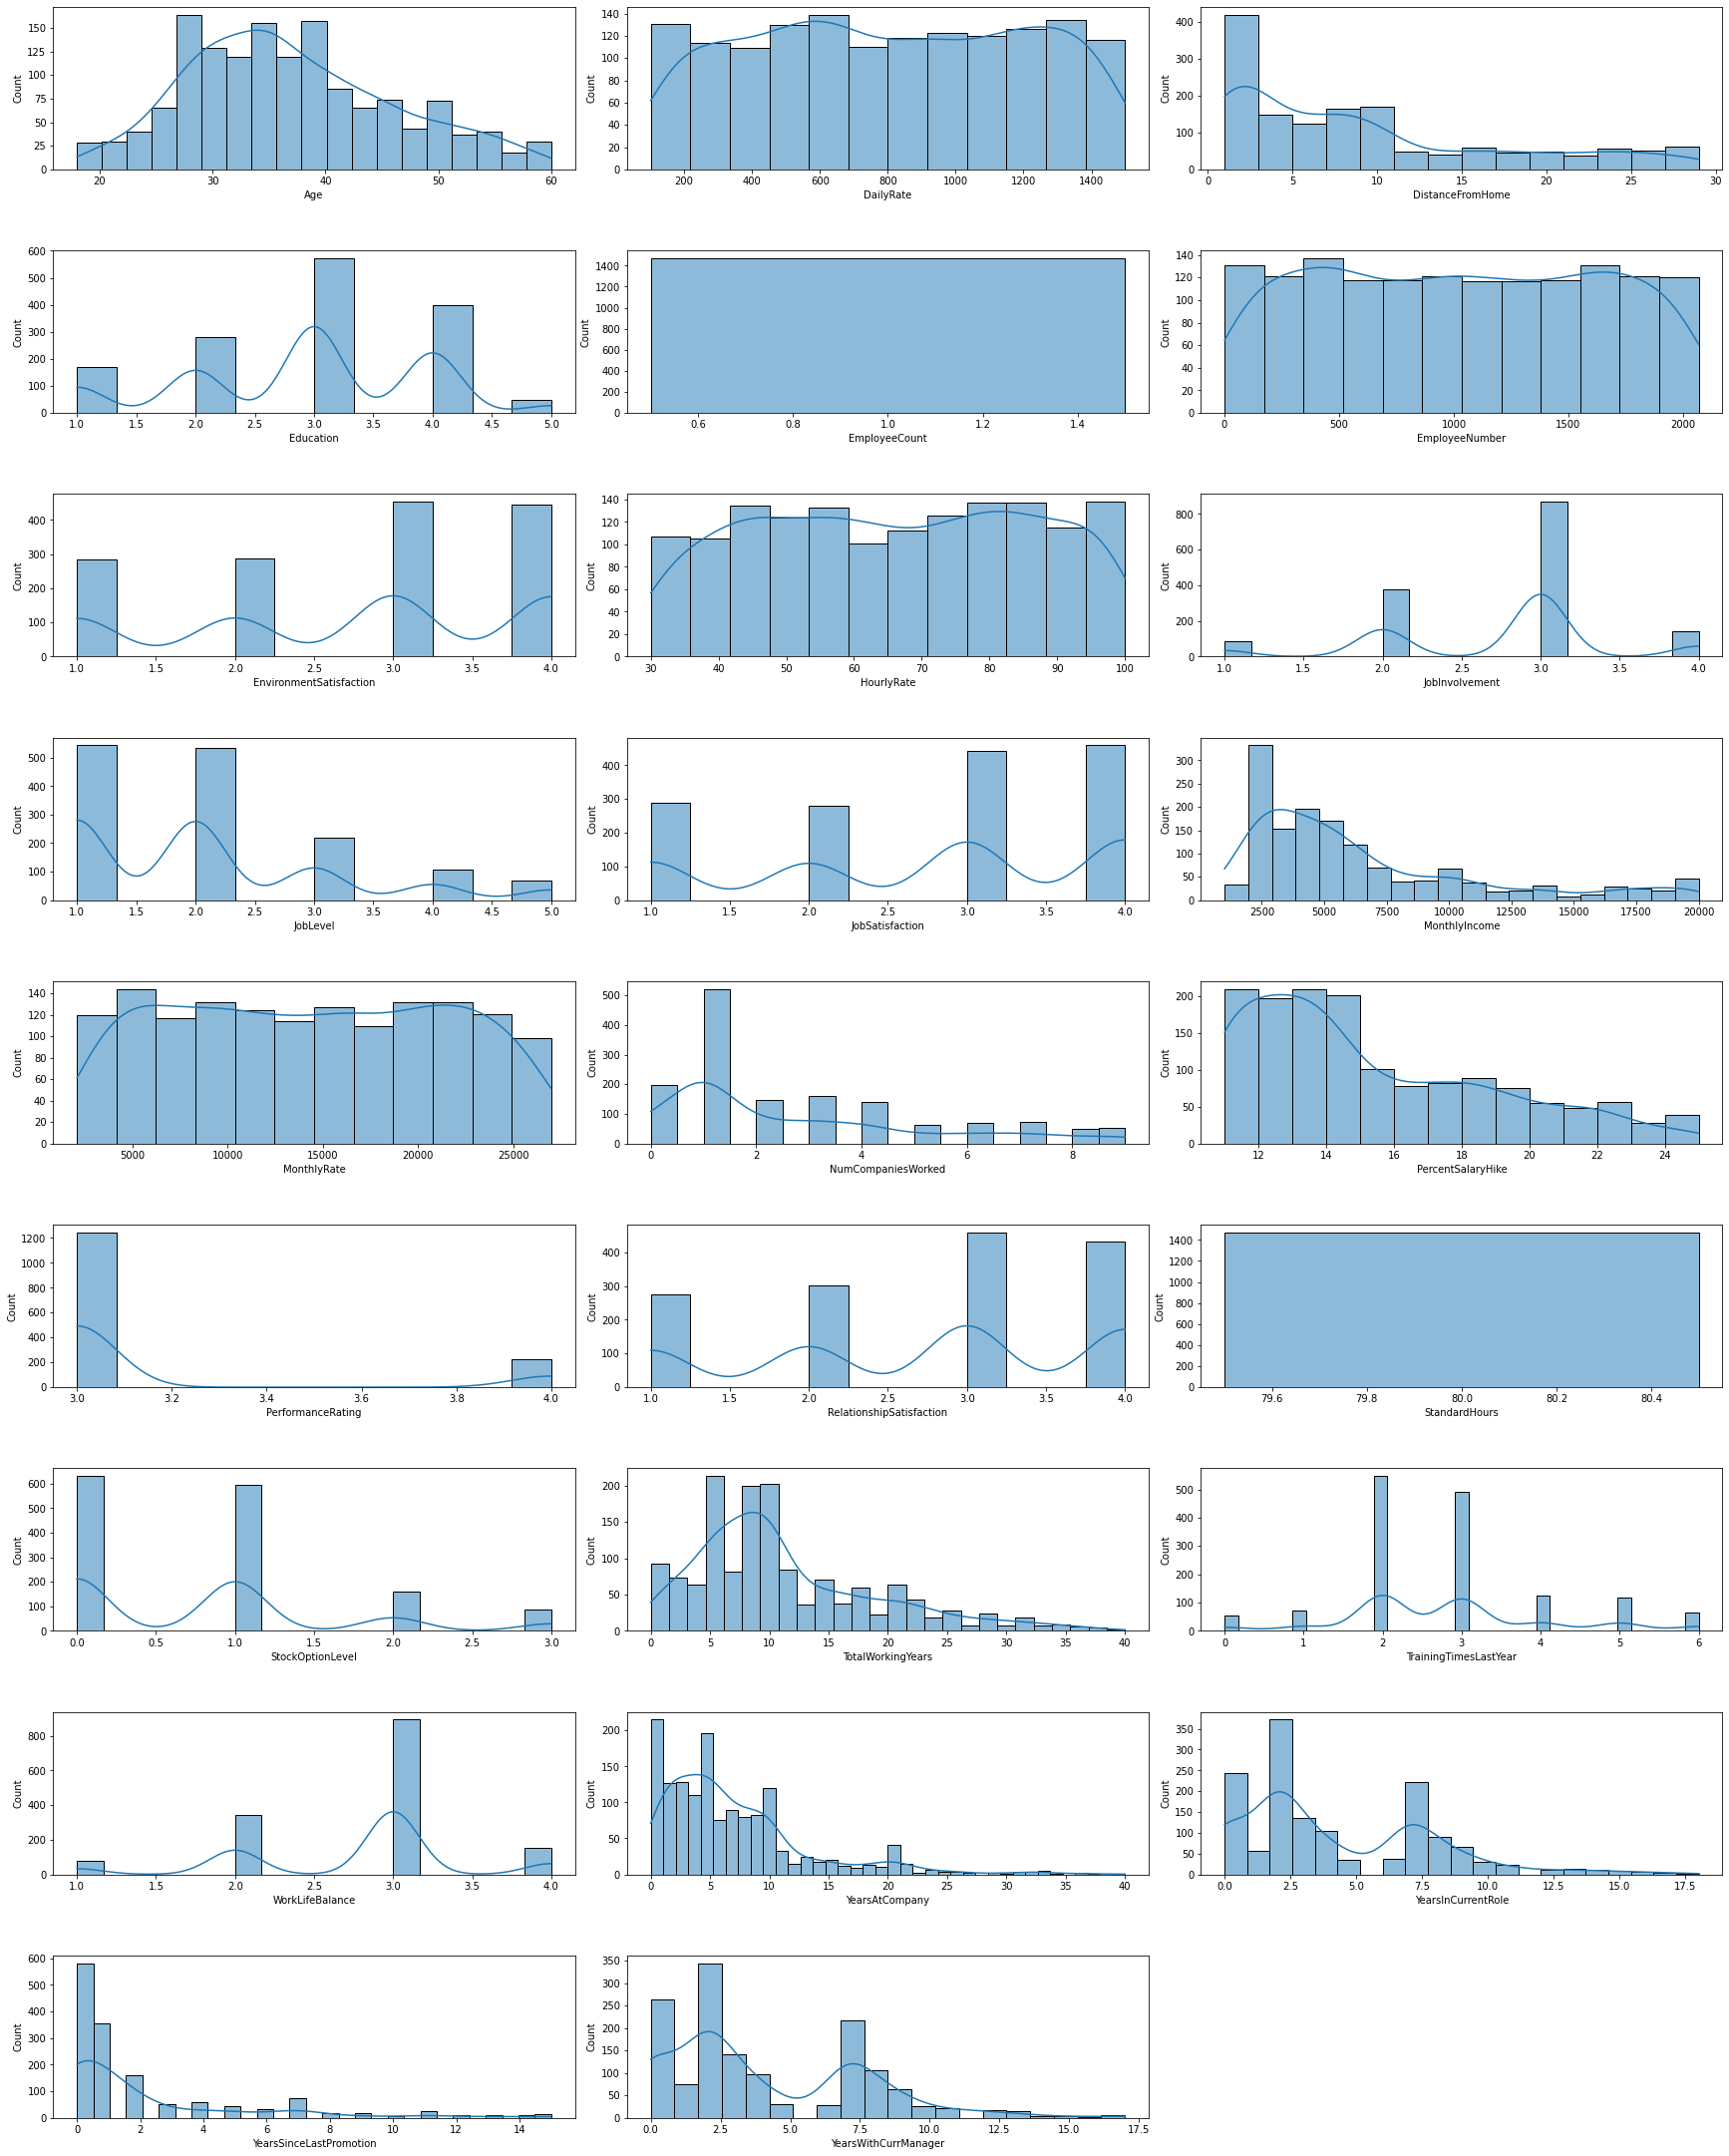

In [8]:
plt.figure(figsize=(30,30))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.1)
x = 1

for i in con:
    plt.subplot(9,3,x)
    x = x+1
    sns.histplot(data = ibm_data, x = i, kde=True)
plt.show()

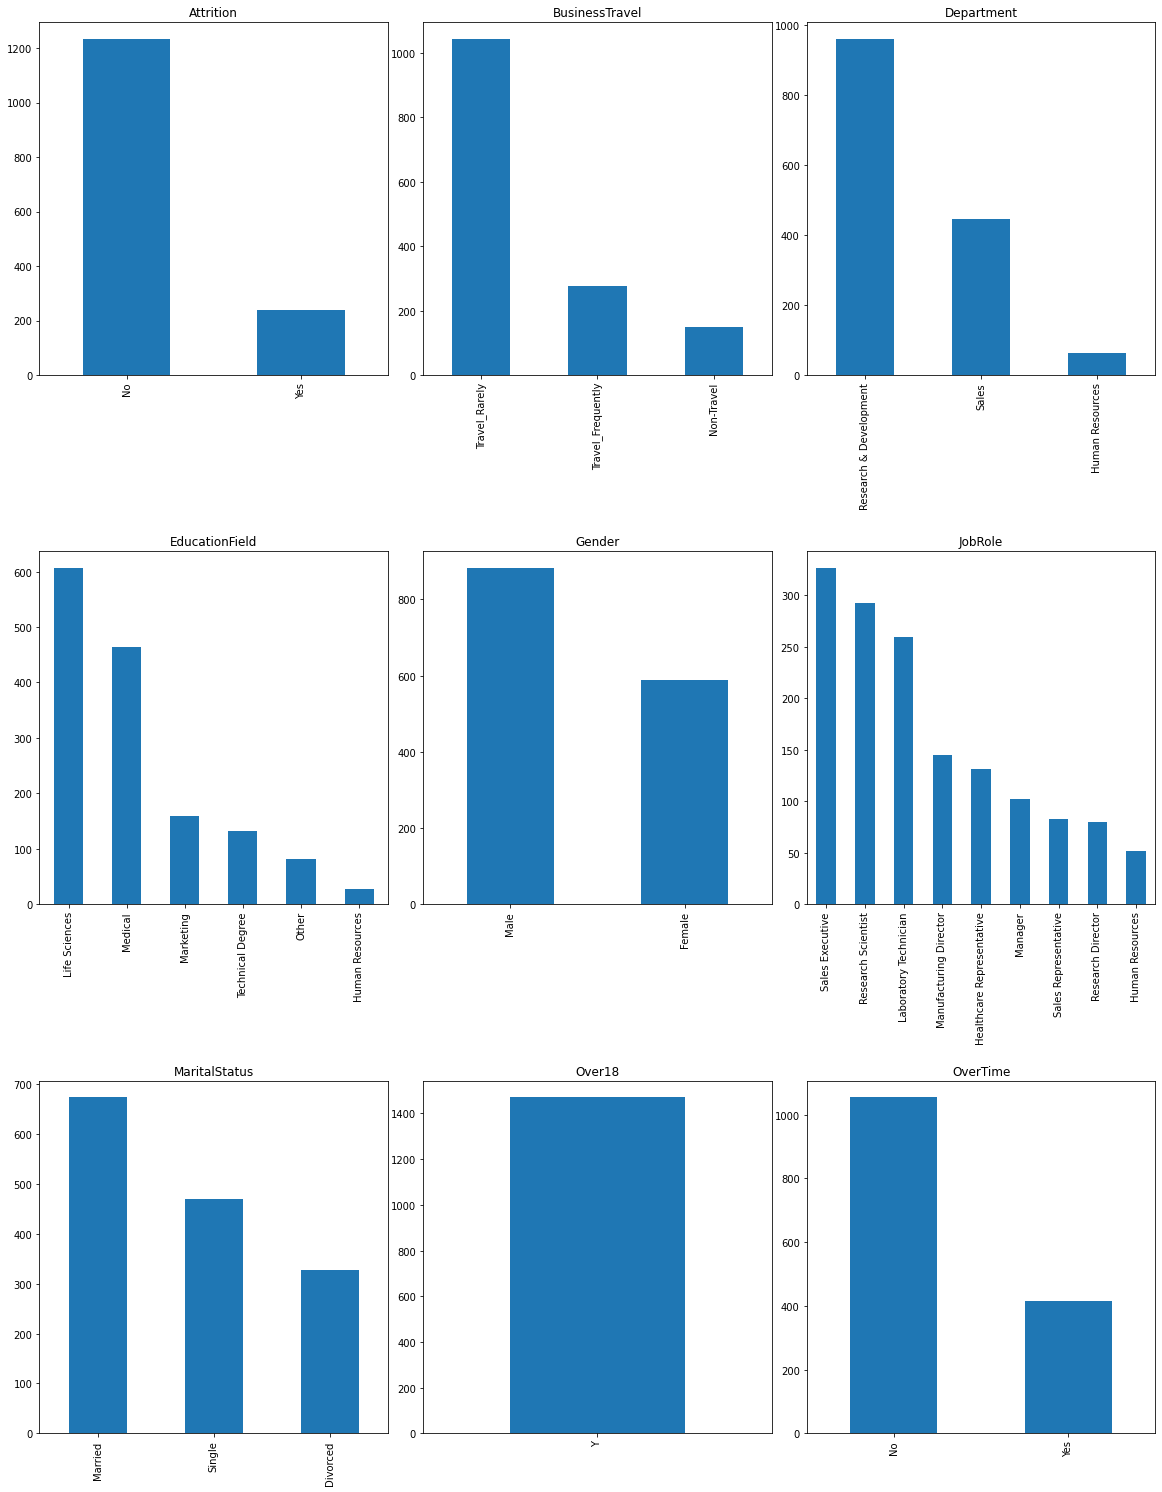

In [9]:
plt.figure(figsize=(20,20))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.1)
for i in cat:
    plt.subplot(3,3,x)
    x = x+1
    ibm_data[i].value_counts().plot(kind='bar')
    plt.title(i)
plt.show()

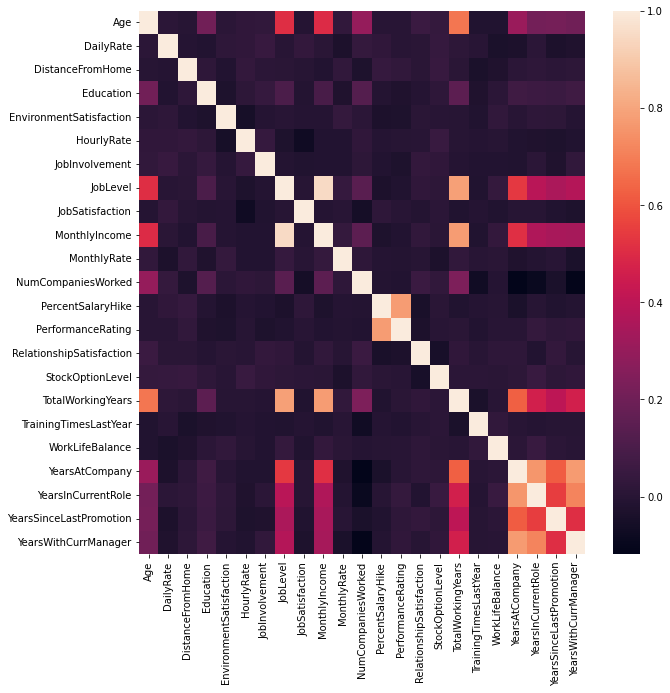

In [23]:
plt.figure(figsize=(10,10))
sns.heatmap(ibm_data.corr())
plt.show()

## Collinear Feature Removal

By removing collinear features, we can improve the performance and interpretability of the model by reducing the noise in the data and increasing the relevance of the predictor variables.

In [20]:
ibm_data = ibm_data.drop(columns= ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'])

In [30]:
from sklearn.preprocessing import LabelEncoder

df = ibm_data
le = LabelEncoder()
# target variable
y = pd.DataFrame(le.fit_transform(df['Attrition']),columns=df[['Attrition']].columns)

# features encoded
x_cat = pd.get_dummies(df[cat].drop(columns='Attrition'))
x_con = df[con]
X = x_con.join(x_cat)
X = X.drop(columns= ['EmployeeCount', 'EmployeeNumber', 'Over18_Y', 'StandardHours'])

df_encoded = pd.concat([X,y], axis = 1)

In [ ]:
df_encoded.head()

In [32]:
# https://www.kaggle.com/code/vincentlugat/ibm-attrition-analysis-and-prediction?scriptVersionId=10006574&cellId=36

# Threshold for removing correlated variables
threshold = 0.8 #lowering the threshold to 0.7 from example 

# Absolute value correlation matrix
corr_matrix = df_encoded.corr().abs()
corr_matrix.head()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.head()

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove :' % (len(to_drop)))

X = X.drop(columns = to_drop)

to_drop

There are 6 columns to remove :


['MonthlyIncome',
 'Department_Sales',
 'Gender_Male',
 'JobRole_Human Resources',
 'JobRole_Sales Executive',
 'OverTime_Yes']

# Decision Tree Classifier

## Preprocessing 

In [33]:
X.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'EducationField_Human Resources',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'Gender_Female',
       'JobRole_Healthcare Representative', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturi

## Train, Validation, Test Sets for Decision Tree

In [34]:
from sklearn.model_selection import train_test_split
# https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c

df = ibm_data
# 80:10:10
train_size=0.8
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)
# X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

# test_size = 0.5
# X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
# print(X_valid.shape),print(y_valid.shape)
print(X_test.shape),print(y_test.shape)

(1176, 45)
(1176, 1)
(294, 45)
(294, 1)


(None, None)

In [65]:
X_train.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
1090,29,441,8,1,3,39,1,2,1,9715,...,0,0,0,0,0,0,1,0,1,0
826,38,433,1,3,3,37,4,1,3,2844,...,0,0,0,0,0,0,1,0,1,0
665,47,1454,2,4,4,65,2,1,4,3294,...,0,0,0,0,1,0,0,1,0,1
415,34,296,6,2,4,33,1,1,3,2351,...,0,0,0,0,1,1,0,0,1,0
1364,28,783,1,2,3,42,2,2,4,6834,...,0,0,0,1,0,0,1,0,0,1


## Feature Selection


In [7]:
!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# Going to conduct various wrapper methods for feature selection on Decision Tree and SVM

# forward selection method
# http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/#sequentialfeatureselector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS 
from sklearn.tree import DecisionTreeClassifier


#Define Sequential Forward Selection (sfs)
sfs = SFS(DecisionTreeClassifier(),
           k_features=(40,51),
          #  forward=True,
           floating=False,
           scoring = 'roc_auc'
           )
#Use SFS to select the top 5 features 
sfs.fit(X_train, y_train)

#Create a dataframe for the SFS results 
df_SFS_results = pd.DataFrame(sfs.subsets_).transpose()
df_SFS_results

,feature_idx,cv_scores,avg_score,feature_names
1,"(7,)","[0.6099180007809449, 0.6761955650547689, 0.675...",0.651095,"(JobLevel,)"
2,"(7, 49)","[0.7010282441754524, 0.7008415709324072, 0.764...",0.701025,"(JobLevel, OverTime_No)"
3,"(7, 15, 49)","[0.6959521020434726, 0.7417178733636121, 0.744...",0.739945,"(JobLevel, StockOptionLevel, OverTime_No)"
4,"(7, 15, 44, 49)","[0.7072107249772225, 0.7636922254875768, 0.790...",0.753585,"(JobLevel, StockOptionLevel, JobRole_Sales Exe..."
5,"(7, 15, 25, 44, 49)","[0.6960822595340361, 0.7821266363879241, 0.809...",0.764816,"(JobLevel, StockOptionLevel, BusinessTravel_Tr..."
6,"(7, 15, 25, 43, 44, 49)","[0.7070154887413771, 0.7952845311247663, 0.833...",0.776722,"(JobLevel, StockOptionLevel, BusinessTravel_Tr..."
7,"(7, 15, 25, 43, 44, 49, 50)","[0.7070154887413771, 0.7952845311247663, 0.833...",0.776722,"(JobLevel, StockOptionLevel, BusinessTravel_Tr..."
8,"(7, 15, 25, 40, 43, 44, 49, 50)","[0.6840426916569049, 0.7967539406892867, 0.829...",0.771213,"(JobLevel, StockOptionLevel, BusinessTravel_Tr..."
9,"(7, 15, 25, 40, 42, 43, 44, 49, 50)","[0.7051282051282051, 0.7967539406892866, 0.802...",0.770976,"(JobLevel, StockOptionLevel, BusinessTravel_Tr..."
10,"(7, 13, 15, 25, 40, 42, 43, 44, 49, 50)","[0.7010282441754523, 0.7594175794816992, 0.834...",0.765566,"(JobLevel, PerformanceRating, StockOptionLevel..."


## Model Tuning

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score

In [85]:
# Decision Tree Grid Search

dt = DecisionTreeClassifier()

#Parameters to run through GridSearch
param_grid = {
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':range(1,20),
    'min_samples_split':range(2,10),
    'min_samples_leaf':range(1,5)
            }

#Run GridSearch
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring = 'roc_auc')
grid_search.fit(X_train, y_train)

#Print out best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 9, 'splitter': 'random'}
Best score:  0.7652122217911692


In [87]:
# dt_final = DecisionTreeClassifier(random_state = random_state,
#                                   criterion = 'entropy',
#                                   max_depth = 4,
#                                   min_samples_leaf = 2,
#                                   min_samples_split = 5,
#                                   splitter = 'random')

# rf_cross_val = cross_validate(dt_final, X_train, y_train, cv=5, scoring = ('roc_auc','accuracy','f1','precision','recall'))

#The roc_auc, accuracy, and f-score following 5-fold cross-validation and its standard deviation
# print("Mean scores - Decision Tree Best Model; ", 'roc_auc:{:.3f}'.format(np.mean(rf_cross_val['test_roc_auc'])), 'accuracy:{:.3f}'.format(np.mean(rf_cross_val['test_accuracy'])),'f-score:{:.3f}'.format(np.mean(rf_cross_val['test_f1'])))
# print("St. Dev. of Scores - Decision Tree Best Model: ",   'roc_auc:{:.3f}'.format(np.std(rf_cross_val['test_roc_auc'])), 'accuracy:{:.3f}'.format(np.std(rf_cross_val['test_accuracy'])),'f-score:{:.3f}'.format(np.std(rf_cross_val['test_f1'])))

Mean scores - Decision Tree Best Model;  roc_auc:0.720 accuracy:0.848 f-score:0.247
St. Dev. of Scores - Decision Tree Best Model:  roc_auc:0.065 accuracy:0.020 f-score:0.141


In [ ]:
import sklearn.metrics
sklearn.metrics.get_scorer_names()

In [114]:
#Best Decision Tree Model used on validation set

dt_final = DecisionTreeClassifier(random_state = random_state,
                                  criterion = 'gini',
                                  max_depth = 4,
                                  min_samples_leaf = 1,
                                  min_samples_split = 4,
                                  splitter = 'random'
                                  )

rf_cross_val = cross_validate(dt_final, X_train, y_train, cv=5, scoring = ('roc_auc','accuracy','f1','precision','recall'))

#The roc_auc, accuracy, and f-score following 5-fold cross-validation and its standard deviation
print("Mean scores - Decision Tree Best Model; ", 'roc_auc:{:.3f}'.format(np.mean(rf_cross_val['test_roc_auc'])), 'accuracy:{:.3f}'.format(np.mean(rf_cross_val['test_accuracy'])),'f-score:{:.3f}'.format(np.mean(rf_cross_val['test_f1'])))
print("St. Dev. of Scores - Decision Tree Best Model: ",   'roc_auc:{:.3f}'.format(np.std(rf_cross_val['test_roc_auc'])), 'accuracy:{:.3f}'.format(np.std(rf_cross_val['test_accuracy'])),'f-score:{:.3f}'.format(np.std(rf_cross_val['test_f1'])))

Mean scores - Decision Tree Best Model;  roc_auc:0.720 accuracy:0.841 f-score:0.315
St. Dev. of Scores - Decision Tree Best Model:  roc_auc:0.045 accuracy:0.015 f-score:0.081


## Confusion Matrix of Tuned Model Predictions of test set

In [116]:
dt_final.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4, min_samples_split=4, random_state=42,
                       splitter='random')

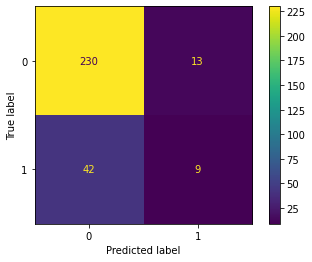

In [117]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = dt_final.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [101]:
rf_cross_val = cross_validate(dt_final, X_test, y_test, cv=5, scoring = ('roc_auc','accuracy','f1','precision','recall'))
print("Mean scores - Decision Tree Best Model; ", 'roc_auc:{:.3f}'.format(np.mean(rf_cross_val['test_roc_auc'])), 'accuracy:{:.3f}'.format(np.mean(rf_cross_val['test_accuracy'])),'f-score:{:.3f}'.format(np.mean(rf_cross_val['test_f1'])),'precision:{:.3f}'.format(np.mean(rf_cross_val['test_precision'])),'recall:{:.3f}'.format(np.mean(rf_cross_val['test_recall'])))

Mean scores - Decision Tree Best Model;  roc_auc:0.627 accuracy:0.793 f-score:0.101 precision:0.152 recall:0.080


In [ ]:
# y_score = dt_final.predict_proba(X_test)[:,1]
# model_performance_plot(dt_final)

## Vizualiation of Decision Tree

In [102]:
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot

features = list(X_test.columns)
# features.remove("Attrition")

In [103]:
#utility from SIADS 542: Supervised Learning
from adspy_shared_utilities import plot_decision_tree 

In [104]:
target_values = ['0','1']

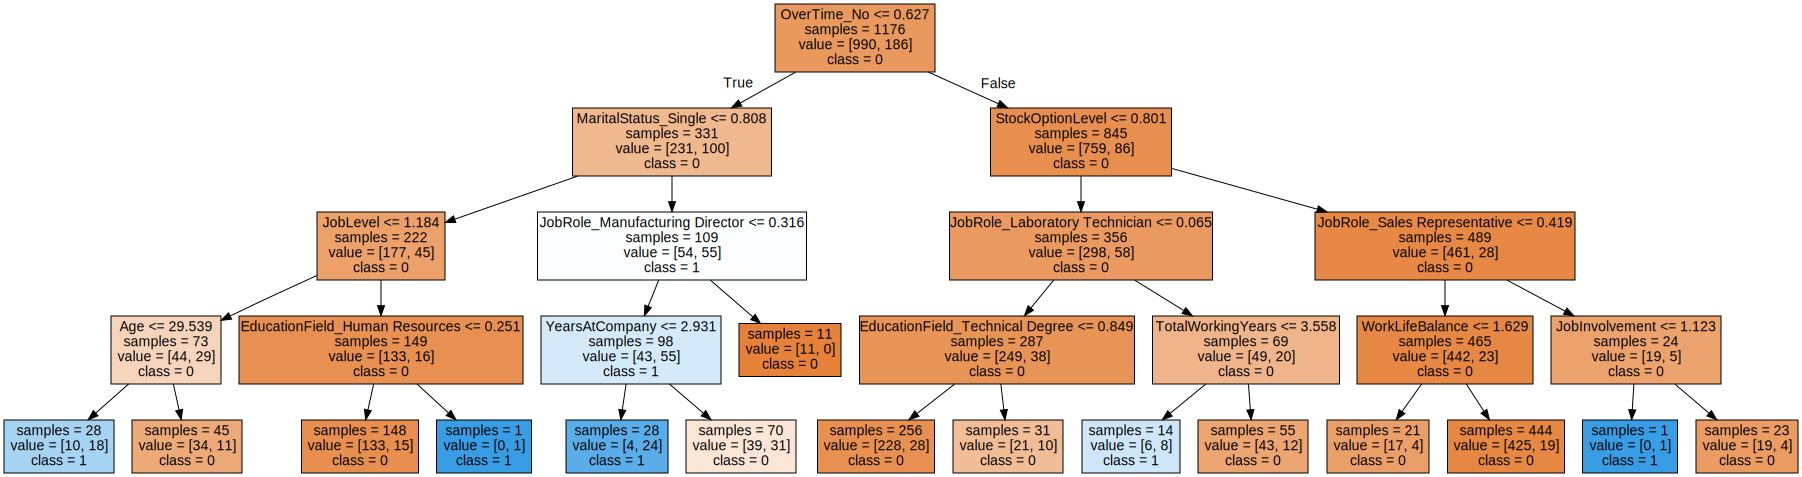

In [118]:
plot_decision_tree(dt_final, features, target_values)

## SHAP Score for DT

In [142]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [143]:
explainer = shap.TreeExplainer(dt_final)
shap_values = explainer.shap_values(X_test)
# shap_values

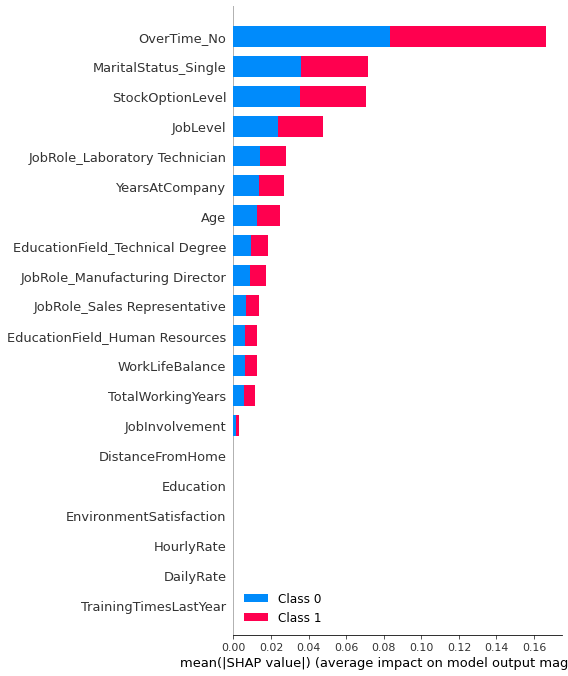

In [156]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

In [144]:
# Expected/Base/Reference value = the value that would be predicted if we didn’t know any features of the current output”
print('Expected Value:', explainer.expected_value)

Expected Value: [0.84183673 0.15816327]


In [154]:
X_test.iloc[0,:]

Age                                    49
DailyRate                            1245
DistanceFromHome                       18
Education                               4
EnvironmentSatisfaction                 4
HourlyRate                             58
JobInvolvement                          2
JobLevel                                5
JobSatisfaction                         3
MonthlyRate                          2125
NumCompaniesWorked                      1
PercentSalaryHike                      17
PerformanceRating                       3
RelationshipSatisfaction                3
StockOptionLevel                        1
TotalWorkingYears                      31
TrainingTimesLastYear                   5
WorkLifeBalance                         3
YearsAtCompany                         31
YearsInCurrentRole                      9
YearsSinceLastPromotion                 0
YearsWithCurrManager                    9
BusinessTravel_Non-Travel               0
BusinessTravel_Travel_Frequently  

In [155]:
y_test.iloc[0]

Attrition    0
Name: 473, dtype: int64

In [147]:
#Force Plot for a single observation for a single class 0
shap.initjs()
shap.force_plot(explainer.expected_value[0],
shap_values[0][0,:], X_test.iloc[0])

This observation:

*   0.90 probability of this obersvation belonging to attrition 0
*   StockOptionLevel, JobLevel,MaritalStatus_Single have high values that increase the probability of belonging to attrition 0



# SVM Classifier

In [20]:
from sklearn import svm

svm = svm.SVC()



#Parameters to run through GridSearch
param_grid = {
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':range(1,10),
    'min_samples_split':range(1,10),
    'min_samples_leaf':range(1,5)
            }

#Run GridSearch
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring = 'roc_auc')
grid_search.fit(X_train, y_train)

#Print out best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Streaming output truncated to the last 5000 lines.
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when 

KeyError: ignored

# Functions

In [72]:
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.offline as py

def model_performance_plot(model) : 
        
    #plot roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_score) , 3)
    fpr, tpr, t = roc_curve(y_test, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : ",
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    #subplots
    fig = tls.make_subplots(rows=1, cols=2, print_grid=False, 
                        subplot_titles=('ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve'))
    

    fig.append_trace(trace3,1,1)
    fig.append_trace(trace4,1,1)
    fig.append_trace(trace5,1,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance</b><br>'+str(model),
                        autosize = True, height = 500,width = 830,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
    fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis"].update(dict(title = "recall"), range = [0,1.05])
    fig["layout"]["yaxis"].update(dict(title = "precision"), range = [0,1.05])
    fig.layout.titlefont.size = 14
    
    py.iplot(fig)

In [134]:
def shap_force(clf, clf_step_name, index, 
               X_train_df, y_train,
               explainer, shap_vals):
  
    """Takes in a fitted classifier Pipeline, the name of the classifier step,
        the X training DataFrame, the y train array, a shap explainer, and the
        shap values to print the ground truth and predicted label and display
        the shap force plot for the record specified by index.
    Args:
        clf (estimator): An sklearn Pipeline with a fitted classifier as the final step.
        clf_step_name (str): The name given to the classifier step of the pipe.
        X_train_df (DataFrame): A Pandas DataFrame from the train-test-split
            used to train the classifier, with column names corresponding to
            the feature names.
        y_train (series or array): Subset of y data used for training.
        index (int): The index of the observation of interest.
        explainer (shap explainer): A fitted shap.TreeExplainer object.
        shap_vals (array): The array of shap values.
    Returns:
        Figure: Shap force plot showing the breakdown of how the model made
            its prediction for the specified record in the training set.
    """    
    
    
    ## Store model prediction and ground truth label
    pred = clf.named_steps[clf_step_name].predict(X_train_df.iloc[index,:])
    true_label = y_train.iloc[index]
    
    
    ## Assess accuracy of prediction
    if true_label == pred:
        accurate = 'Correct!'
    else:
        accurate = 'Incorrect'
    
    
    ## Print output that checks model's prediction against true label
    print('***'*12)
    # Print ground truth label for row at index
    print(f'Ground Truth Label: {true_label}')
    print()
    # Print model prediction for row at index
    print(f'Model Prediction:  {pred} -- {accurate}')
    print('***'*12)
    print()
    
    
    ## Plot the prediction's explanation
    fig = shap.force_plot(explainer.expected_value,
                              shap_vals[index,:],
                              X_train_df.iloc[index,:])
    
    
    return fig